In [19]:
import numpy as np
import pandas as pd
from typing import Mapping, List, Tuple
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_boston, load_iris, load_wine, load_digits, \
    load_breast_cancer, load_diabetes, fetch_mldata
from  matplotlib.collections import LineCollection
import time
from pandas.api.types import is_string_dtype, is_object_dtype, is_categorical_dtype, is_bool_dtype
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from pdpbox import pdp
from rfpimp import *
from scipy.integrate import cumtrapz
from stratx.partdep import *
from stratx.ice import *

%config InlineBackend.figure_formats = ['png']#,'svg']

def df_string_to_cat(df:pd.DataFrame) -> dict:
    catencoders = {}
    for colname in df.columns:
        if is_string_dtype(df[colname]) or is_object_dtype(df[colname]):
            df[colname] = df[colname].astype('category').cat.as_ordered()
            catencoders[colname] = df[colname].cat.categories
    return catencoders


def df_cat_to_catcode(df):
    for col in df.columns:
        if is_categorical_dtype(df[col]):
            df[col] = df[col].cat.codes + 1

# NYC apt rent

## Download, prep data

*Data use rules prevent me from storing this data in this repo*. Download the data set from Kaggle. (You must be a registered Kaggle user and must be logged in.) Go to the Kaggle [data page](https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries/data) and save `train.json` into the `data` directory underneath this notebook.

In [20]:
df = pd.read_json('data/train.json')

# Create ideal numeric data set w/o outliers etc...
df = df[(df.price > 1_000) & (df.price < 10_000)]
df = df[df.bathrooms <= 6]  # There's almost no data for 6 and above with small sample
df = df[(df.longitude != 0) | (df.latitude != 0)]
df = df[(df['latitude'] > 40.55) & (df['latitude'] < 40.94) &
        (df['longitude'] > -74.1) & (df['longitude'] < -73.67)]
df_rent = df[['bedrooms', 'bathrooms', 'latitude', 'longitude', 'price']]
df_rent.head()

,bedrooms,bathrooms,latitude,longitude,price
10,3,1.5,40.7145,-73.9425,3000
10000,2,1.0,40.7947,-73.9667,5465
100004,1,1.0,40.7388,-74.0018,2850
100007,1,1.0,40.7539,-73.9677,3275
100013,4,1.0,40.8241,-73.9493,3350


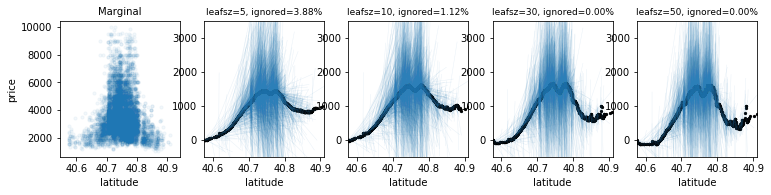

In [21]:
df_rent = df_rent[-10_000:]  # get a small subsample
X = df_rent.drop('price', axis=1)
y = df_rent['price']

plot_stratpd_gridsearch(X, y, 'latitude', 'price',
                        min_samples_leaf_values=[5,10,30,50],
                        yrange=(-500,3500),
                        marginal_alpha=0.05
                        )

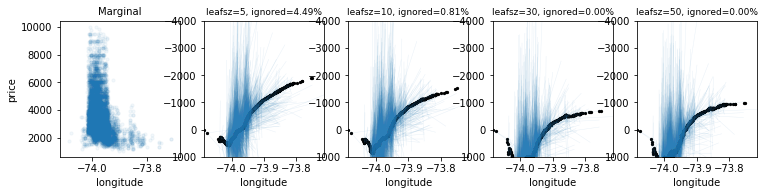

In [22]:
plot_stratpd_gridsearch(X, y, 'longitude', 'price',
                        min_samples_leaf_values=[5,10,30,50],
                        yrange=(1000,-4000),
                        marginal_alpha=0.05
                        )

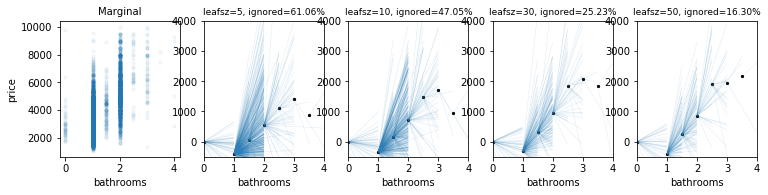

In [23]:
plot_stratpd_gridsearch(X, y, 'bathrooms', 'price',
                        min_samples_leaf_values=[5,10,30,50],
                        yrange=(-500,4000),
                        slope_line_alpha=.15)

# Bulldozer sales

## Download, prep data

*Data use rules prevent me from storing this data in this repo*. Download the data set from Kaggle. (You must be a registered Kaggle user and must be logged in.) Go to the Kaggle [Blue Book for Bulldozers](https://www.kaggle.com/c/bluebook-for-bulldozers/data) and save `Train.csv` into the `data` directory underneath this notebook.

The raw csv is superslow to load, but feather is fast so load as csv then save as feather, which is what this example uses below.


In [24]:
#df = pd.read_csv("data/Train.csv", parse_dates=['saledate'], low_memory=False)
#df.to_feather("data/bulldozer-train.feather")

In [25]:
def onecol(df, X, y, colname, axes, row, xrange, yrange):
    axes[row, 0].scatter(X[colname], y, alpha=0.07, s=1)
    axes[row, 0].set_ylabel("SalePrice")  # , fontsize=12)
    axes[row, 0].set_xlabel(colname)  # , fontsize=12)

    plot_stratpd(X, y, colname, 'SalePrice', ax=axes[row, 1], xrange=xrange,
                 yrange=yrange, show_ylabel=False,
                 verbose=False, slope_line_alpha=.07)

    axes[row, 1].set_xlabel(colname)  # , fontsize=12)
    axes[row, 1].set_ylim(*yrange)

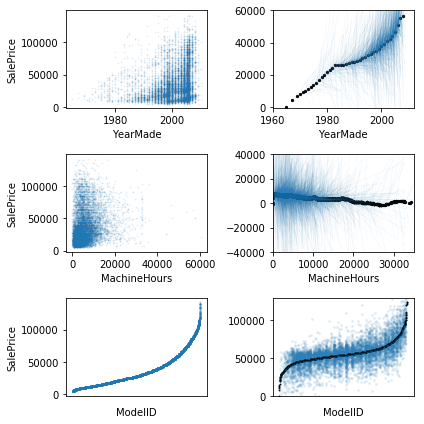

In [26]:
df = pd.read_feather("../notebooks/data/bulldozer-train.feather")
df['MachineHours'] = df['MachineHoursCurrentMeter']  # shorten name
basefeatures = ['ModelID', 'YearMade', 'MachineHours']

df = df[df['YearMade'] >= 1960]
df = df[df['MachineHours'] > 0]

df = df[basefeatures + ['SalePrice']].reindex()
df = df.dropna(axis='rows')  # drop any rows with nan

# Get subsample; it's a (sorted) timeseries so get last records not random
df = df.iloc[-10_000:]  # take only last 10,000 records

X, y = df[basefeatures], df['SalePrice']

# print(f"Avg bulldozer price is {np.mean(y):.2f}$")

fig, axes = plt.subplots(3, 2, figsize=(6, 6))

onecol(df, X, y, 'YearMade', axes, 0, xrange=(1960, 2012), yrange=(-1000, 60000))
onecol(df, X, y, 'MachineHours', axes, 1, xrange=(0, 35_000),
       yrange=(-40_000, 40_000))

# show marginal plot sorted by model's sale price
sort_indexes = y.argsort()

modelids = X['ModelID'].values
sorted_modelids = modelids[sort_indexes]
sorted_ys = y.values[sort_indexes]
cats = modelids[sort_indexes]
ncats = len(cats)

axes[2, 0].set_xticks(range(1, ncats + 1))
axes[2, 0].set_xticklabels([])
# axes[2, 0].get_xaxis().set_visible(False)

xlocs = np.arange(1, ncats + 1)
axes[2, 0].scatter(xlocs, sorted_ys, alpha=0.2, s=2)  # , label="observation")
axes[2, 0].set_ylabel("SalePrice")  # , fontsize=12)
axes[2, 0].set_xlabel('ModelID')  # , fontsize=12)
axes[2, 0].tick_params(axis='x', which='both', bottom=False)

plot_catstratpd(X, y, 'ModelID', 'SalePrice',
                min_samples_leaf=5,
                use_weighted_avg=False,
                ax=axes[2, 1],
                sort='ascending',
                yrange=(0, 130000),
                show_ylabel=False,
                alpha=0.1,
                style='scatter',
                # style='strip',
                marker_size=3,
                show_xticks=False,
                verbose=False)
plt.tight_layout()
plt.show()

# Synthetic human weight data

In [27]:
def toy_weight_data(n):
    df = pd.DataFrame()
    nmen = n // 2
    nwomen = n // 2
    df['sex'] = ['M'] * nmen + ['F'] * nwomen
    df.loc[df['sex'] == 'F', 'pregnant'] = np.random.randint(0, 2, size=(nwomen,))
    df.loc[df['sex'] == 'M', 'pregnant'] = 0
    df.loc[df['sex'] == 'M', 'height'] = 5 * 12 + 8 + np.random.uniform(-7, +8,
                                                                        size=(nmen,))
    df.loc[df['sex'] == 'F', 'height'] = 5 * 12 + 5 + np.random.uniform(-4.5, +5,
                                                                        size=(nwomen,))
    df.loc[df['sex'] == 'M', 'education'] = 10 + np.random.randint(0, 8, size=nmen)
    df.loc[df['sex'] == 'F', 'education'] = 12 + np.random.randint(0, 8, size=nwomen)
    df['weight'] = 120 \
                   + (df['height'] - df['height'].min()) * 10 \
                   + df['pregnant'] * 30 \
                   - df['education'] * 1.5
    df['pregnant'] = df['pregnant'].astype(bool)
    df['education'] = df['education'].astype(int)
    return df

In [28]:
toy_weight_data(6)

,sex,pregnant,height,education,weight
0,M,False,71.635900,11,193.897466
1,M,False,66.337775,13,137.916220
2,M,False,64.756389,16,117.602355
3,F,True,62.596153,18,123.000000
4,F,False,65.210192,14,125.140389
5,F,False,65.800587,12,134.044337


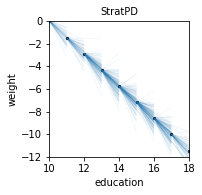

In [45]:
df_raw = toy_weight_data(2000)
df = df_raw.copy()
catencoders = df_string_to_cat(df)
df_cat_to_catcode(df)
df['pregnant'] = df['pregnant'].astype(int)
X = df.drop('weight', axis=1)
y = df['weight']
figsize = (2.5, 2.5)

fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_stratpd(X, y, 'education', 'weight', ax=ax,
             # min_samples_leaf=2,
             yrange=(-12, 0), slope_line_alpha=.1, show_ylabel=True)
#    ax.get_yaxis().set_visible(False)
ax.set_title("StratPD", fontsize=10)
ax.set_xlim(10,18)
ax.set_xticks([10,12,14,16,18])

Text(0.5, 1.0, 'StratPD')

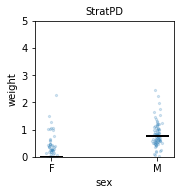

In [46]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_catstratpd(X, y, 'sex', 'weight', ax=ax,
                # min_samples_leaf=50,
                alpha=.2,
                catnames={1: 'F', 2: 'M'},
                yrange=(0, 5),
                )
ax.set_title("StratPD", fontsize=10)

Text(0.5, 1.0, 'StratPD')

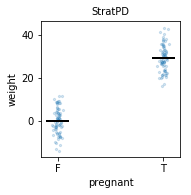

In [49]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_catstratpd(X, y, 'pregnant', 'weight', ax=ax,
                # min_samples_leaf=50,
                alpha=.2,
                catnames={0: 'F', 1: 'T'},
#                yrange=(0, 5),
                )
ax.set_title("StratPD", fontsize=10)

# Reproduce variable interaction "big X" data from ICE paper

Peeking Inside the Black Box: Visualizing Statistical Learning with Plots of Individual Conditional Expectation by Alex Goldstein, Adam Kapelner†, Justin Bleich‡, and Emil Pitkin. https://arxiv.org/abs/1309.6392#

In [31]:
def bigX_data(n):
    x1 = np.random.uniform(-1, 1, size=n)
    x2 = np.random.uniform(-1, 1, size=n)
    x3 = np.random.uniform(-1, 1, size=n)

    y = 0.2 * x1 - 5 * x2 + 10 * x2 * np.where(x3 >= 0, 1, 0) + np.random.normal(0, 1,
                                                                                 size=n)
    df = pd.DataFrame()
    df['x1'] = x1
    df['x2'] = x2
    df['x3'] = x3
    df['y'] = y
    return df

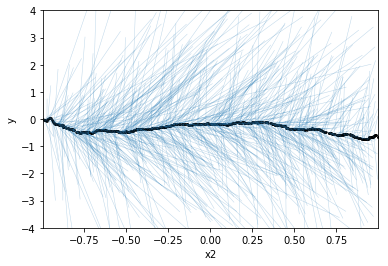

In [32]:
n = 1000
df = bigX_data(n=n)
X = df.drop('y', axis=1)
y = df['y']

plot_stratpd(X, y, 'x2', 'y', yrange=(-4, 4),
             min_samples_leaf=5,
             pdp_marker_size=2)
plt.show()

# Toy weather data with sine curve

In [33]:
def toy_weather_data():
    def temp(x): return np.sin((x+365/2)*(2*np.pi)/365)
    def noise(state): return np.random.normal(-5, 5, sum(df['state'] == state))

    df = pd.DataFrame()
    df['dayofyear'] = range(1,365+1)
    df['state'] = np.random.choice(['CA','CO','AZ','WA'], len(df))
    df['temperature'] = temp(df['dayofyear'])
    df.loc[df['state']=='CA','temperature'] = 70 + df.loc[df['state']=='CA','temperature'] * noise('CA')
    df.loc[df['state']=='CO','temperature'] = 40 + df.loc[df['state']=='CO','temperature'] * noise('CO')
    df.loc[df['state']=='AZ','temperature'] = 90 + df.loc[df['state']=='AZ','temperature'] * noise('AZ')
    df.loc[df['state']=='WA','temperature'] = 60 + df.loc[df['state']=='WA','temperature'] * noise('WA')
    return df

Text(0.5, 1.0, '(b) StratPD')

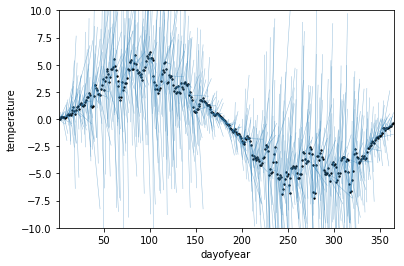

In [34]:
from collections import OrderedDict
df_yr1 = toy_weather_data()
df_yr1['year'] = 1980
df_yr2 = toy_weather_data()
df_yr2['year'] = 1981
df_yr3 = toy_weather_data()
df_yr3['year'] = 1982
df_raw = pd.concat([df_yr1, df_yr2, df_yr3], axis=0)
df = df_raw.copy()
catencoders = df_string_to_cat(df_raw.copy())

names = {'CO': 5, 'CA': 10, 'AZ': 15, 'WA': 20}
df['state'] = df['state'].map(names)
catnames = OrderedDict()
for k,v in names.items():
    catnames[v] = k

X = df.drop('temperature', axis=1)
y = df['temperature']

plot_stratpd(X, y, 'dayofyear', 'temperature',
             yrange=(-10, 10),
             pdp_marker_size=2, slope_line_alpha=.5)

ax.set_title("(b) StratPD")

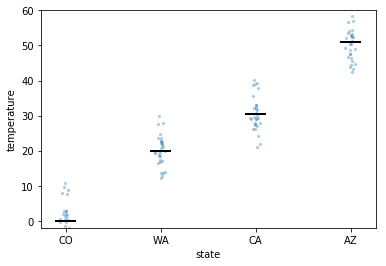

In [35]:
X = df.drop('temperature', axis=1)
y = df['temperature']
plot_catstratpd(X, y, 'state', 'temperature', catnames=catnames,
                min_samples_leaf=30,
                alpha=.3,
                style='strip',
                yrange=(-2, 60)
                )
plt.show()

# Additivity assessment from ICE paper

In [36]:
def additivity_data(n, sd=1.0):
    x1 = np.random.uniform(-1, 1, size=n)
    x2 = np.random.uniform(-1, 1, size=n)

    y = x1 ** 2 + x2 + np.random.normal(0, sd, size=n)
    df = pd.DataFrame()
    df['x1'] = x1
    df['x2'] = x2
    df['y'] = y
    return df

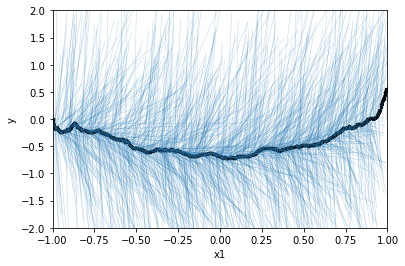

In [37]:
n = 2000
df = additivity_data(n=n, sd=1)  # quite noisy
X = df.drop('y', axis=1)
y = df['y']

plot_stratpd(X, y, 'x1', 'y',
             min_samples_leaf=10,
             yrange=(-2, 2))
plt.show()

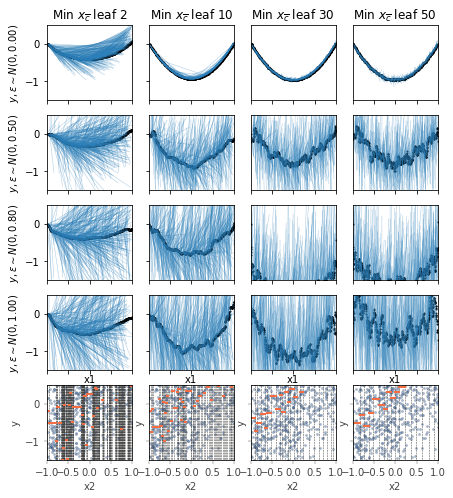

In [38]:
n = 1000
noises = [0, .5, .8, 1.0]
sizes = [2, 10, 30, 50]

fig, axes = plt.subplots(len(noises) + 1, len(sizes), figsize=(7, 8), sharey=True,
                         sharex=True)

row = 0
for sd in noises:
    df = additivity_data(n=n, sd=sd)
    X = df.drop('y', axis=1)
    y = df['y']
    col = 0
    for s in sizes:
        if row == 3:
            show_xlabel = True
        else:
            show_xlabel = False
#         print(f"------------------- noise {sd}, SIZE {s} --------------------")
        if col > 1: axes[row, col].get_yaxis().set_visible(False)
        plot_stratpd(X, y, 'x1', 'y', ax=axes[row, col],
                     min_samples_leaf=s,
                     yrange=(-1.5, .5),
                     pdp_marker_size=1,
                     slope_line_alpha=.4,
                     show_ylabel=False,
                     show_xlabel=show_xlabel)
        if col == 0:
            axes[row, col].set_ylabel(f'$y, \epsilon \sim N(0,{sd:.2f})$')

        if row == 0:
            axes[row, col].set_title("Min $x_{\\overline{c}}$ leaf " + f"{s}",
                                     fontsize=12)
        col += 1
    row += 1

lastrow = len(noises)

axes[lastrow, 0].set_ylabel(f'$y$ vs $x_c$ partition')

col = 0
for s in sizes:
    rtreeviz_univar(axes[lastrow, col],
                    X['x2'], y,
                    min_samples_leaf=s,
                    feature_name='x2',
                    target_name='y',
                    fontsize=10, show={'splits'},
                    split_linewidth=.5,
                    markersize=5)
    axes[lastrow, col].set_xlabel("x2")
    col += 1
    
plt.show()

# Boston

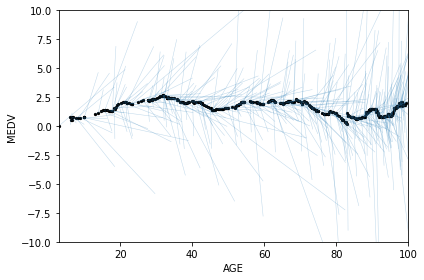

In [39]:
from sklearn.datasets import load_boston, load_diabetes
from stratx.partdep import *

boston = load_boston()
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['MEDV'] = boston.target

X = df.drop('MEDV', axis=1)
y = df['MEDV']

# WORKS ONLY WITH DATAFRAMES AT MOMENT
plot_stratpd(X, y, 'AGE', 'MEDV', yrange=(-10,10))
plt.tight_layout()
plt.show()

# Diabetes

In [40]:
diabetes = load_diabetes()
# WORKS ONLY WITH DATAFRAMES AT MOMENT
df = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
df['y'] = diabetes.target
X = df.drop('y', axis=1)
y = df['y']
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


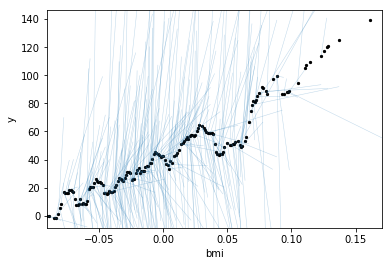

In [41]:
foo = plot_stratpd(X, y, 'bmi', 'y')

In [42]:
X['sex'] = np.where(X.sex<0, 0, 1) # flip negatives to 0 and positives to 1
X['sex'] = X['sex'].astype('category')

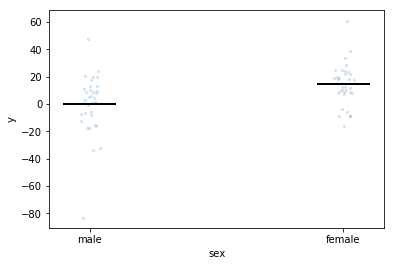

In [43]:
foo = plot_catstratpd(X, y, 'sex', 'y', catnames=['female','male']) # not sure which is male/female actually!